## Описание проекта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.


### Описание данных

Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/taxi.csv',
                   parse_dates=['datetime'],
                   index_col='datetime')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные состоят из количества заказов в интервале 10 минут.

In [3]:
#Ресемплирование по 1часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

Для анализа посмотрим графики:

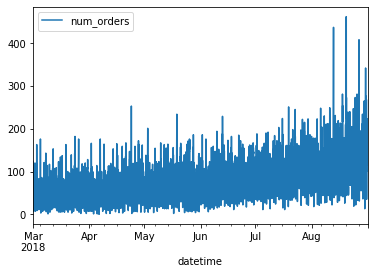

In [5]:
data.plot()

На первый взгляд всреднем количество заказов примерно одинаково по месяцам. Имеем выборку только с марта по сентябрь

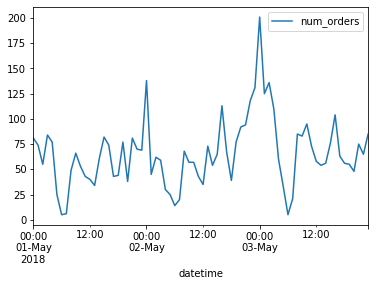

In [6]:
data['2018-05-01':'2018-05-03'].plot()

В 00:00 можем наблюдать пики заказов

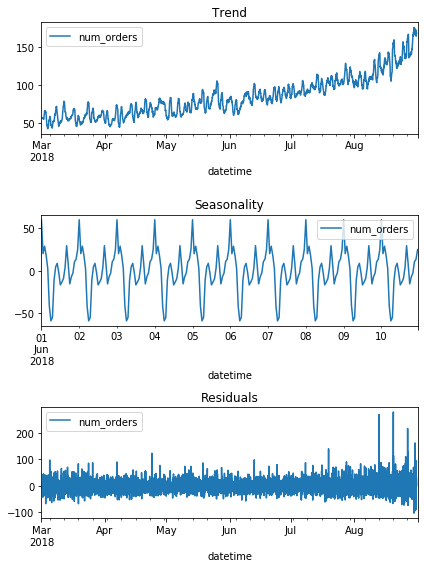

In [7]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-10'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

есть дневная сезонность и восходящий тренд, однако из-зи недостатка данных нельзя уверенно подтвердить тренд роста заказов летом, а также сезонности месяцам.

# 3. Обучение

In [8]:
#создаем функцию выделения признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


- Фактор дня недели пригодится для понимания есть ли изменения от определенного дня (выходные, предвыходные, будни)
- Фактор часа поможет определить есть ли разница от времени суток (в графике выше был виден всплеск поездок по ночам)
- Фактор "Лаг" поможет сравнивать разные периоды времени (например одни сутки или 24 часа)
- Фактор "скользящего среднего" задает общий тренд в течение дня (среднее количестов заказов в течение 4 часов).

In [9]:
make_features(data, 24, 4)

df_train, df_valid_test = train_test_split(data, shuffle=False, test_size=0.2)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.50, shuffle=False)
df_train = df_train.dropna()
df_valid = df_valid.dropna()

features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']
features_valid = df_valid.drop(['num_orders'], axis=1)
target_valid = df_valid['num_orders']
features_test =df_test.drop(['num_orders'], axis=1)
target_test =df_test['num_orders']

### Линейная регрессия

In [10]:
model= LinearRegression()
model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
predicted_valid = model.predict(features_valid)


print('RMSE обучающей выборки:', np.sqrt(mean_squared_error(predicted_train, target_train)))
print('RMSE валидационной выборки: ', np.sqrt(mean_squared_error(predicted_valid, target_valid)))

RMSE обучающей выборки: 24.59845092630094
RMSE валидационной выборки:  34.306752358263566


### Модель Lasso

In [11]:
model_lasso= Lasso()
model_lasso.fit(features_train, target_train)
predicted_train = model_lasso.predict(features_train)
predicted_valid = model_lasso.predict(features_valid)


print('RMSE обучающей выборки:', np.sqrt(mean_squared_error(predicted_train, target_train)))
print('RMSE валидационной выборки: ', np.sqrt(mean_squared_error(predicted_valid, target_valid)))

RMSE обучающей выборки: 24.60528305601828
RMSE валидационной выборки:  34.319974632933224


### Модель Ridge

In [12]:
   
model_ridge = Ridge(random_state=4221, alpha=1)
model_ridge.fit(features_train, target_train)
predicted_train = model_ridge.predict(features_train)
predicted_valid = model_ridge.predict(features_valid)
print('RMSE обучающей выборки: ', np.sqrt(mean_squared_error(predicted_train, target_train)))
print('RMSE валидационной выборки: ', np.sqrt(mean_squared_error(predicted_valid, target_valid)))

RMSE обучающей выборки:  24.59826826754634
RMSE валидационной выборки:  34.3109590612434


### Случайный лес

In [13]:
for i in range(1, 15, 1):
    model_forest = RandomForestRegressor(max_depth=6, random_state=4221, n_estimators=i)
    model_forest.fit(features_train, target_train)
    predicted_train = model_forest.predict(features_train)
    predicted_valid = model_forest.predict(features_valid)
    print('наблюдателей', str(i) + ', RMSE обучающей выборки: ', np.sqrt(mean_squared_error(predicted_train, target_train)))
    print('наблюдателей', str(i) + ', RMSE валидационной выборки: ', np.sqrt(mean_squared_error(predicted_valid, target_valid)))

наблюдателей 1, RMSE обучающей выборки:  23.398485854449763
наблюдателей 1, RMSE валидационной выборки:  38.26962374761384
наблюдателей 2, RMSE обучающей выборки:  21.753739056689508
наблюдателей 2, RMSE валидационной выборки:  35.850744005354215
наблюдателей 3, RMSE обучающей выборки:  21.207957993270263
наблюдателей 3, RMSE валидационной выборки:  35.89479299511921
наблюдателей 4, RMSE обучающей выборки:  20.85256721954099
наблюдателей 4, RMSE валидационной выборки:  35.53611146531641
наблюдателей 5, RMSE обучающей выборки:  20.839427167848722
наблюдателей 5, RMSE валидационной выборки:  35.87285133582033
наблюдателей 6, RMSE обучающей выборки:  20.725841700153907
наблюдателей 6, RMSE валидационной выборки:  35.79059002448629
наблюдателей 7, RMSE обучающей выборки:  20.57895757987628
наблюдателей 7, RMSE валидационной выборки:  35.81392375265826
наблюдателей 8, RMSE обучающей выборки:  20.48048606532483
наблюдателей 8, RMSE валидационной выборки:  35.85378830242264
наблюдателей 9, RM

# 4. Тестирование

In [14]:
model_ridge = Ridge(random_state=4221, alpha=1)
model_ridge.fit(features_train, target_train)
predicted_test = model_ridge.predict(features_test)
print("RMSE тестовой выборки:", np.sqrt(mean_squared_error(predicted_test, target_test)))

RMSE тестовой выборки: 45.61655622964705


In [15]:
model= LinearRegression()
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("RMSE тестовой выборки:", np.sqrt(mean_squared_error(predicted_test, target_test)))

RMSE тестовой выборки: 45.60319975076604


In [16]:
model_forest = RandomForestRegressor(max_depth=6, random_state=4221, n_estimators=14)
model_forest.fit(features_train, target_train)
predicted_test = model_forest.predict(features_test)
print("RMSE тестовой выборки:", np.sqrt(mean_squared_error(predicted_test, target_test)))

RMSE тестовой выборки: 54.415997128644825


In [17]:
model = Lasso()
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("RMSE тестовой выборки:", np.sqrt(mean_squared_error(predicted_test, target_test)))

RMSE тестовой выборки: 45.606251432626046


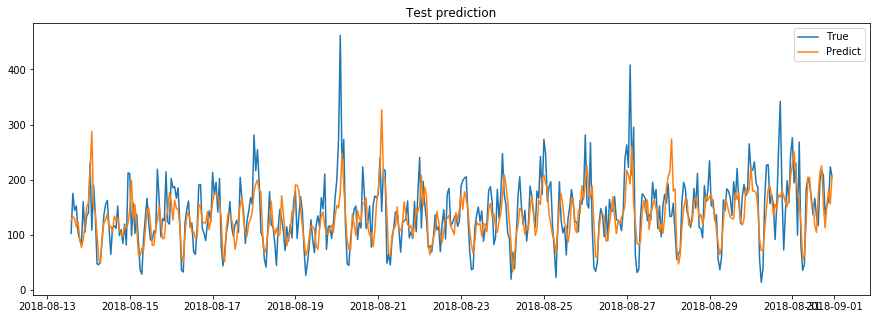

In [18]:
plt.figure(figsize=(15, 5))

plt.plot(target_test, label='True')
plt.plot(target_test.index, predicted_test, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

В целом предсказания выглядят неплохо, однако есть всплески, которые предсказаны либо в слишком большом значении, либо в меньшем. Рассмотрим поближе:

In [19]:
predicted_test_copy = predicted_test.copy()
predicted_test_copy.tolist()

predicted_test_copy = pd.DataFrame(predicted_test_copy, index=target_test.index)

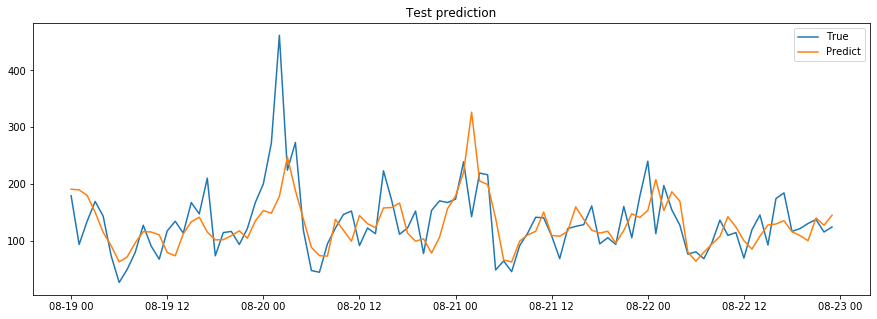

In [20]:

plt.figure(figsize=(15, 5))

plt.plot(target_test['2018-08-19':'2018-08-22'], label='True')
plt.plot(target_test['2018-08-19':'2018-08-22'].index, predicted_test_copy['2018-08-19':'2018-08-22'], label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

Предсказания выглядят усреднено и возможно эти всплески связаны с дневной сезонностью или просто аномальные всплески (08-20 в 00:00) и падение (08-21 в 00:00) связанные с изменениями происходящими в компании (но данных дальше нет).

Text(0.5, 1.0, 'Seasonality')

<Figure size 1080x360 with 0 Axes>

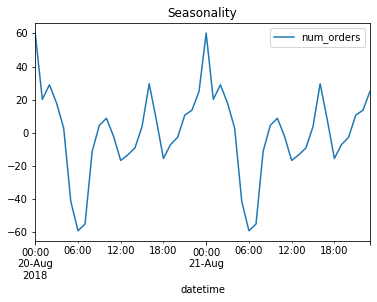

In [21]:
plt.figure(figsize=(15, 5))
#plt.subplot(312)
decomposed.seasonal['2018-08-20':'2018-08-21'].plot()
plt.title('Seasonality')

### Вывод

Параметры подобраны так, что метрика rmse, по крайней мере, у трех моделей ниже 48. Предсказания дают усредненые сглаженные значения в 00:00 в пиковые значения.
Как видно из графика модель иногда ошибается и в моменты особо большого спроса (в 00:00) может выделить недостаточно водителей.